In [36]:
import os
print("Current directory:", os.getcwd())
print("Git branch:", os.popen('git branch --show-current').read().strip())

Current directory: /home/ileniag/buzi_ml4cad_noncvd
Git branch: noncvd-7y-alive


This notebook is used to perform survival analysis

In [37]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, plotting, CoxPHFitter, NelsonAalenFitter
from IPython.display import display

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : True,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 500,
})

%matplotlib inline

In [38]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 27
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
key = dropped_na_key
path = f"data/{n_features}features/{key if extra_path else '' }"
path_models = f"models/{n_features}features/{key if extra_path else '' }"
path_images = f"figures/kaplan_meier_comparision/"
print(path_models)
print(path)
print(path_images)

models/27features/
data/27features/
figures/kaplan_meier_comparision/


In [39]:
# Load the dataset and the extra data
df = pd.read_csv(f"data/raw/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="mixed")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="mixed")

# Create and add target feature `Survive`
df_diff = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: x.days // 365)
years = 7
survive = (df_diff < years) & df["CVD Death"]
survive = (survive + 1) % 2
df[f"Survive{years}Y"] = survive

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
#display(df)

<Axes: xlabel='duration'>

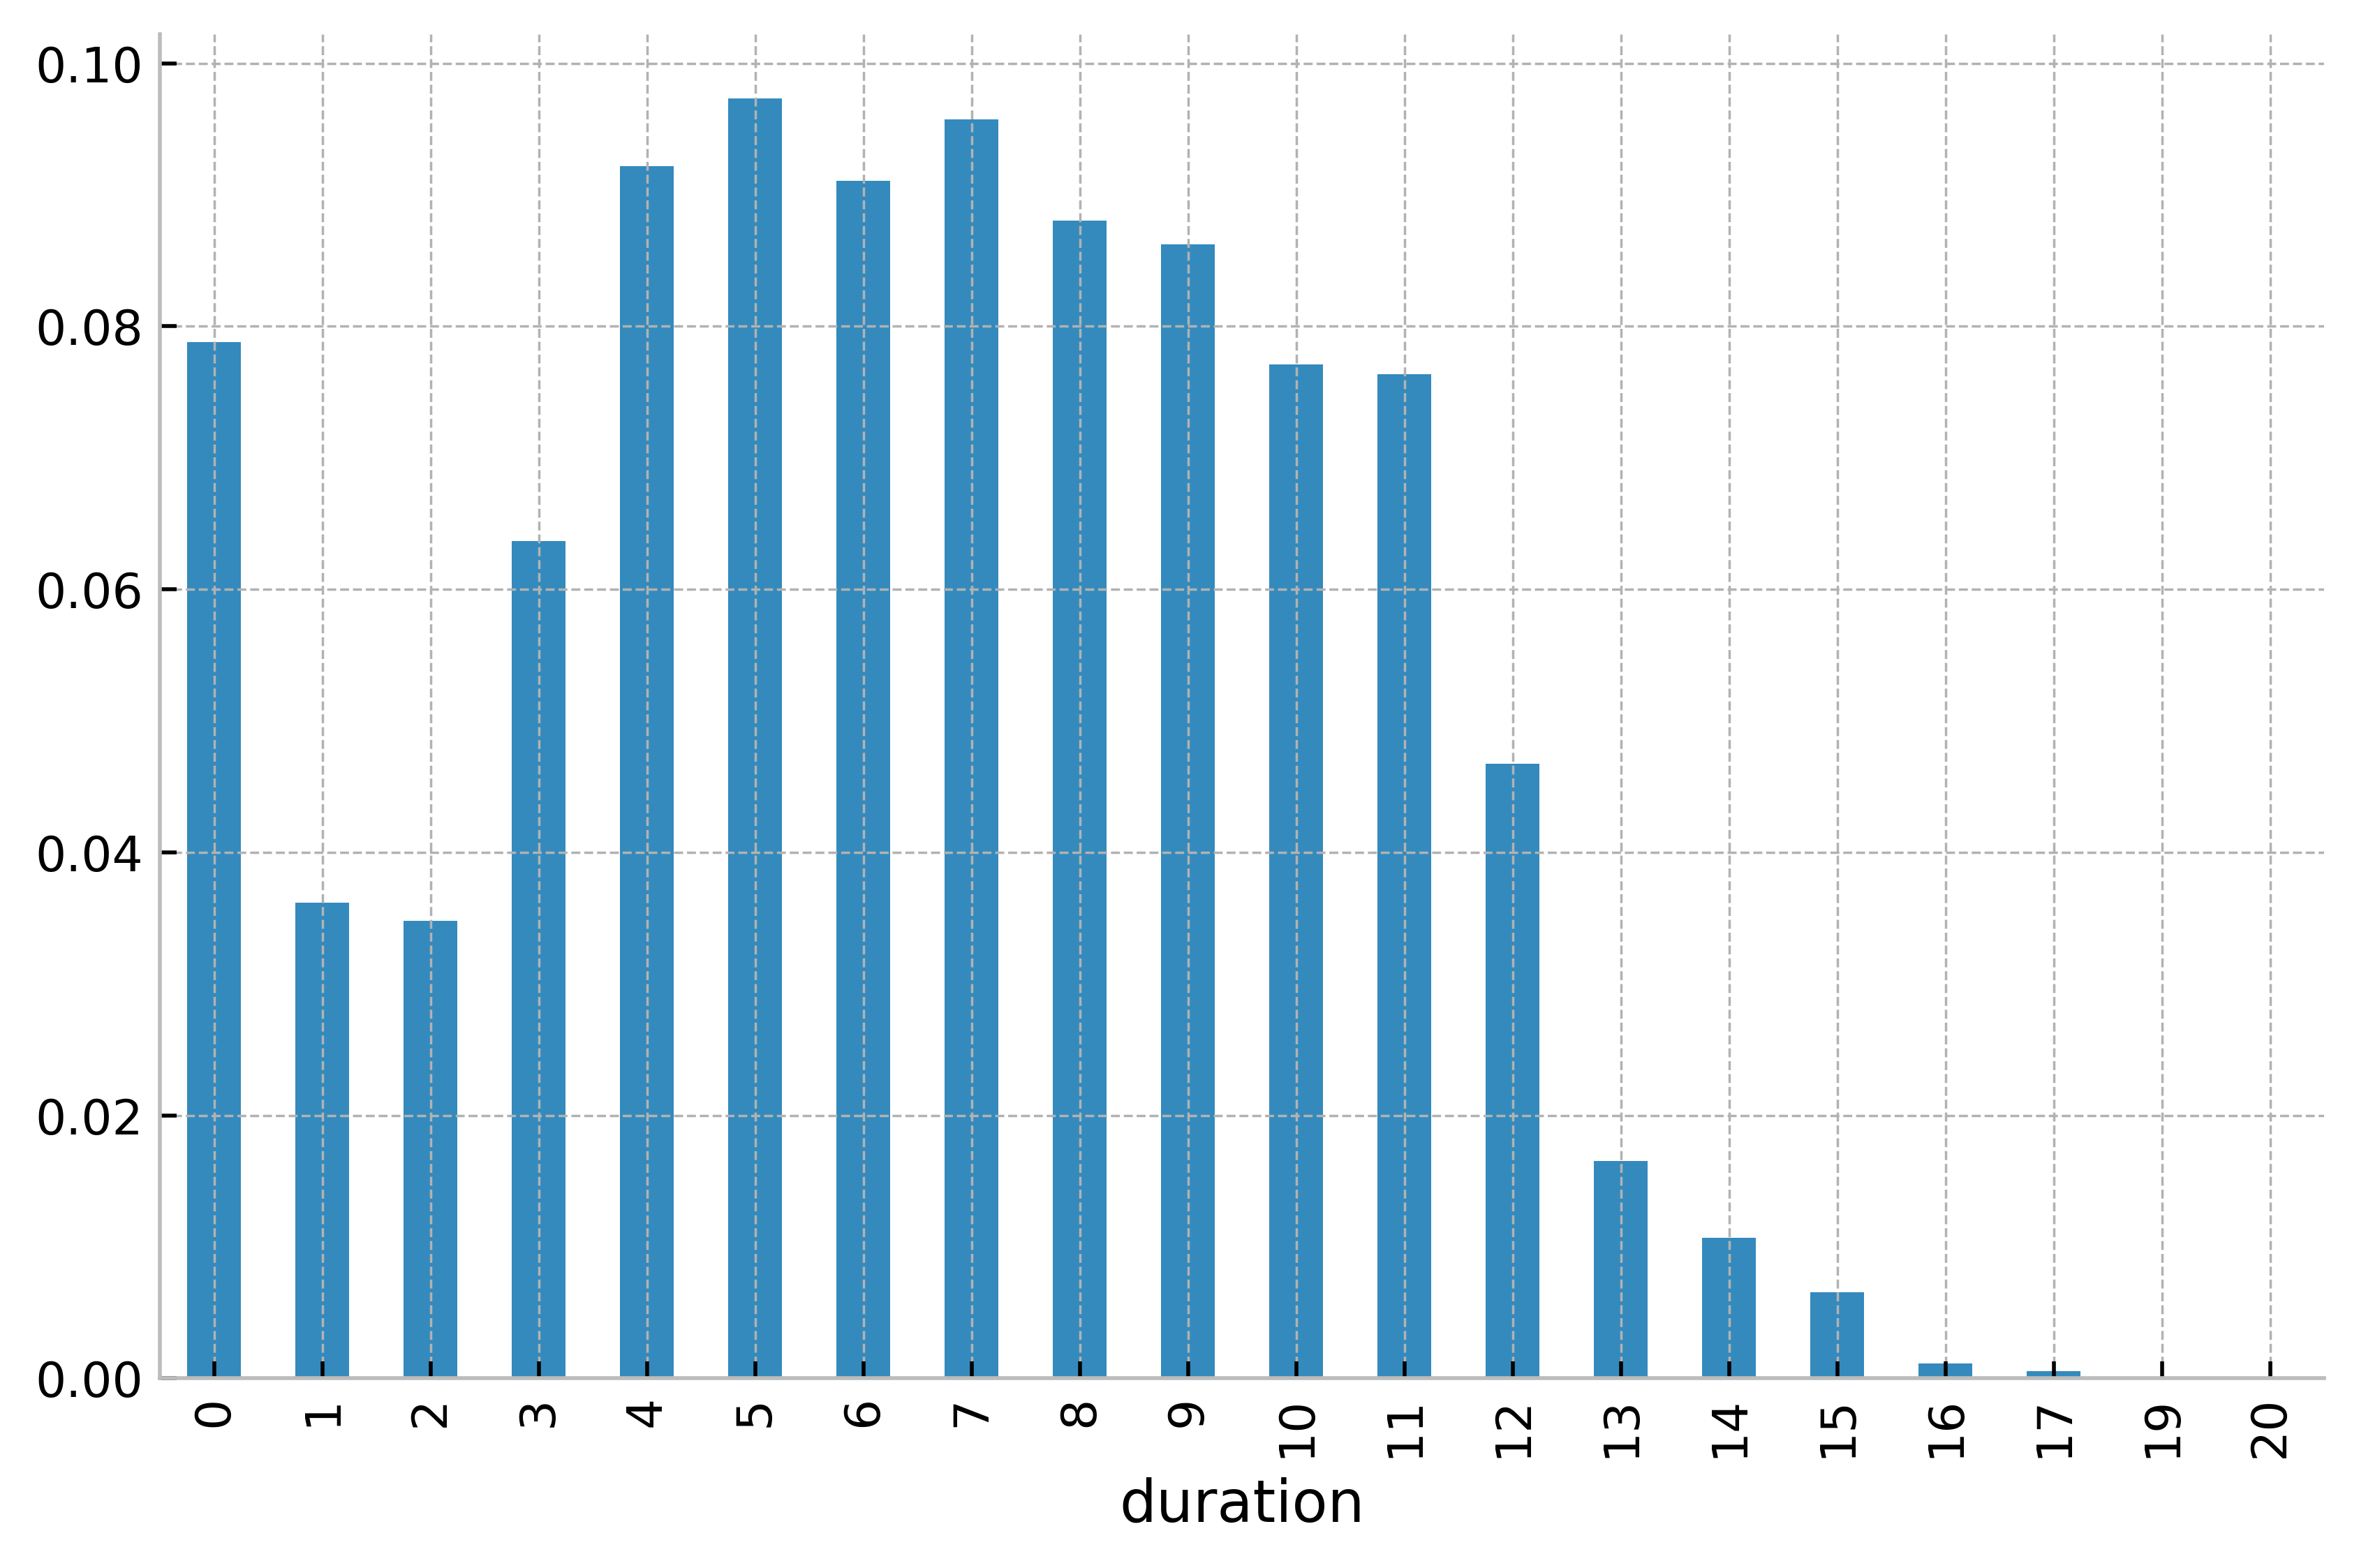

In [40]:
# Birth event: "Data prelievo"
# Death event: "Death7Y"

# Duration and observation features
df_surv = pd.DataFrame()
df_surv["Death7Y"] = df["Death7Y"]
df_surv["duration"] = df_diff
df_surv["observed"] = df["CVD Death"]
df_surv["ID"] = np.random.randint(0, 1e6, size=len(df_surv))
#display(df_surv)
# Plot duration
df_surv["duration"].value_counts(normalize=True).sort_index().plot(kind='bar')
# df_surv.to_csv("data/data_surv.csv")

<Axes: xlabel='duration'>

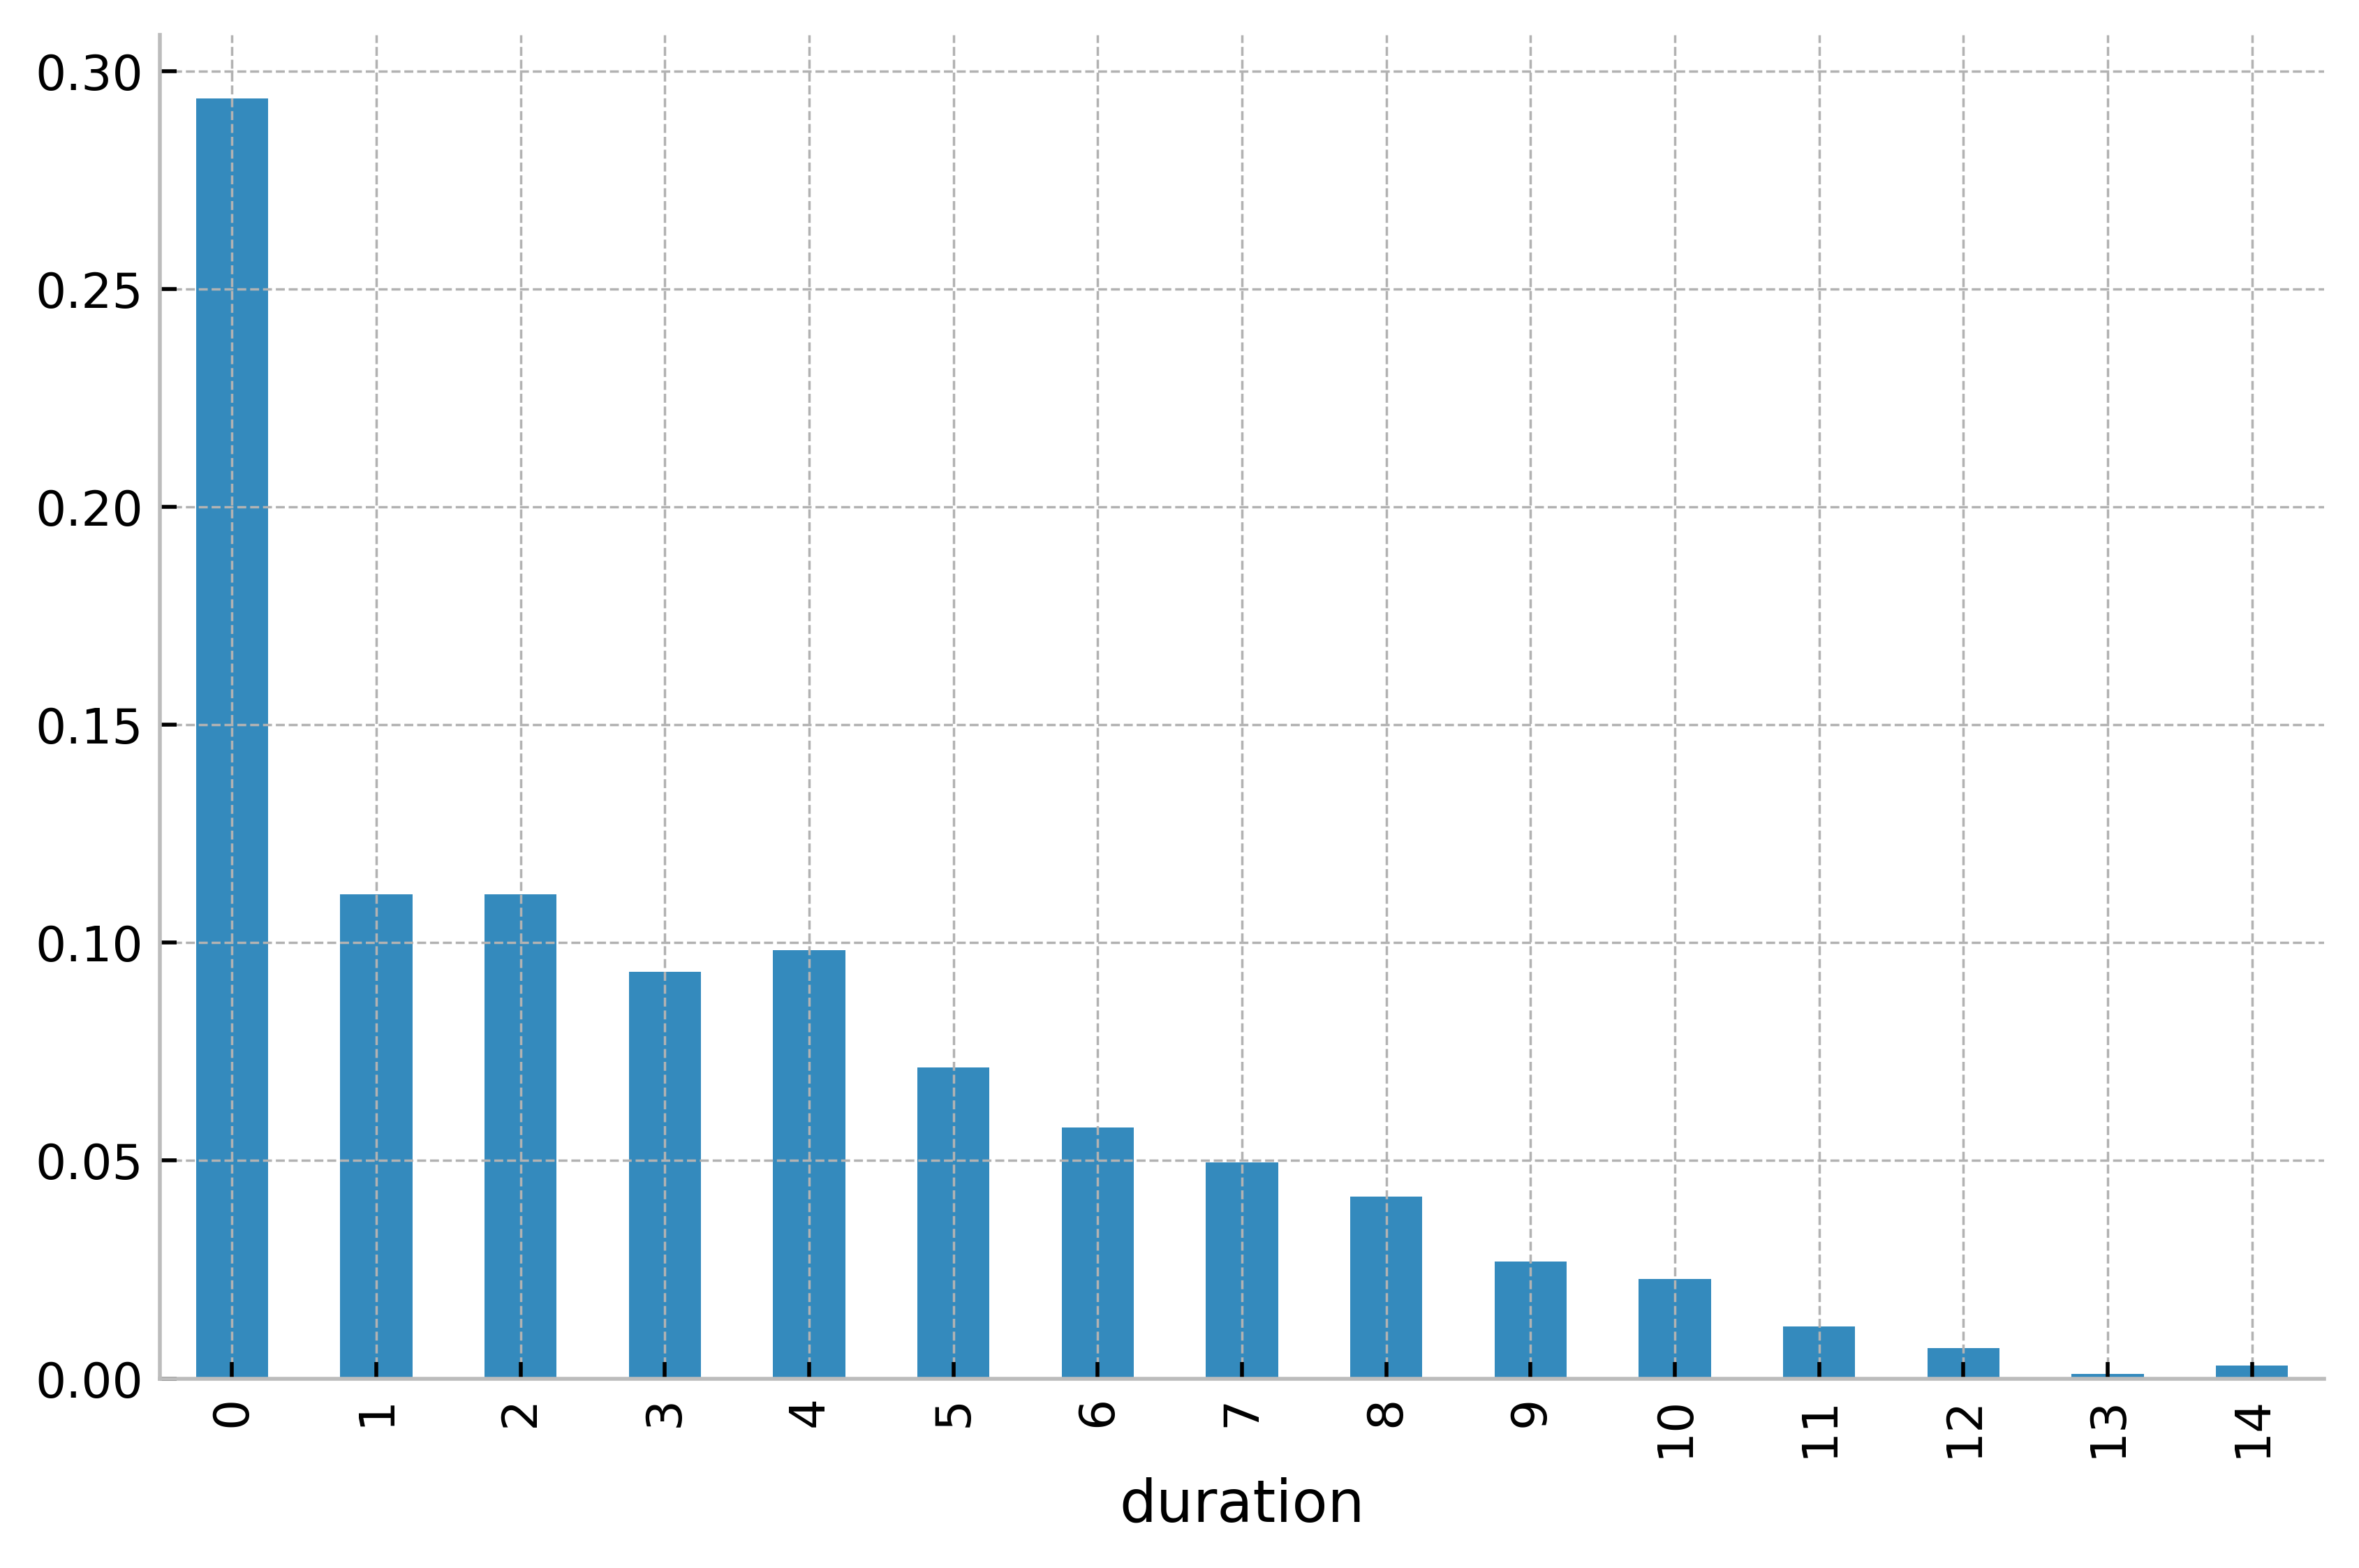

In [41]:
# Data without Right-censoring
#pd.set_option('display.max_rows', 7000)
#display(df_surv[df_surv["observed"]==1])
df_surv[df_surv["observed"]==1]["duration"].value_counts(normalize=True).sort_index().plot(kind='bar')

### Survival Analysis on all the data
The plot indicates the % of CVD patients that survived after n years. 
The probability for surviving more than 7 years is ~86%.

<Axes: title={'center': 'Survival Function of CVD Patients without Right-Censoring'}, xlabel='Years', ylabel='Survive7Y'>

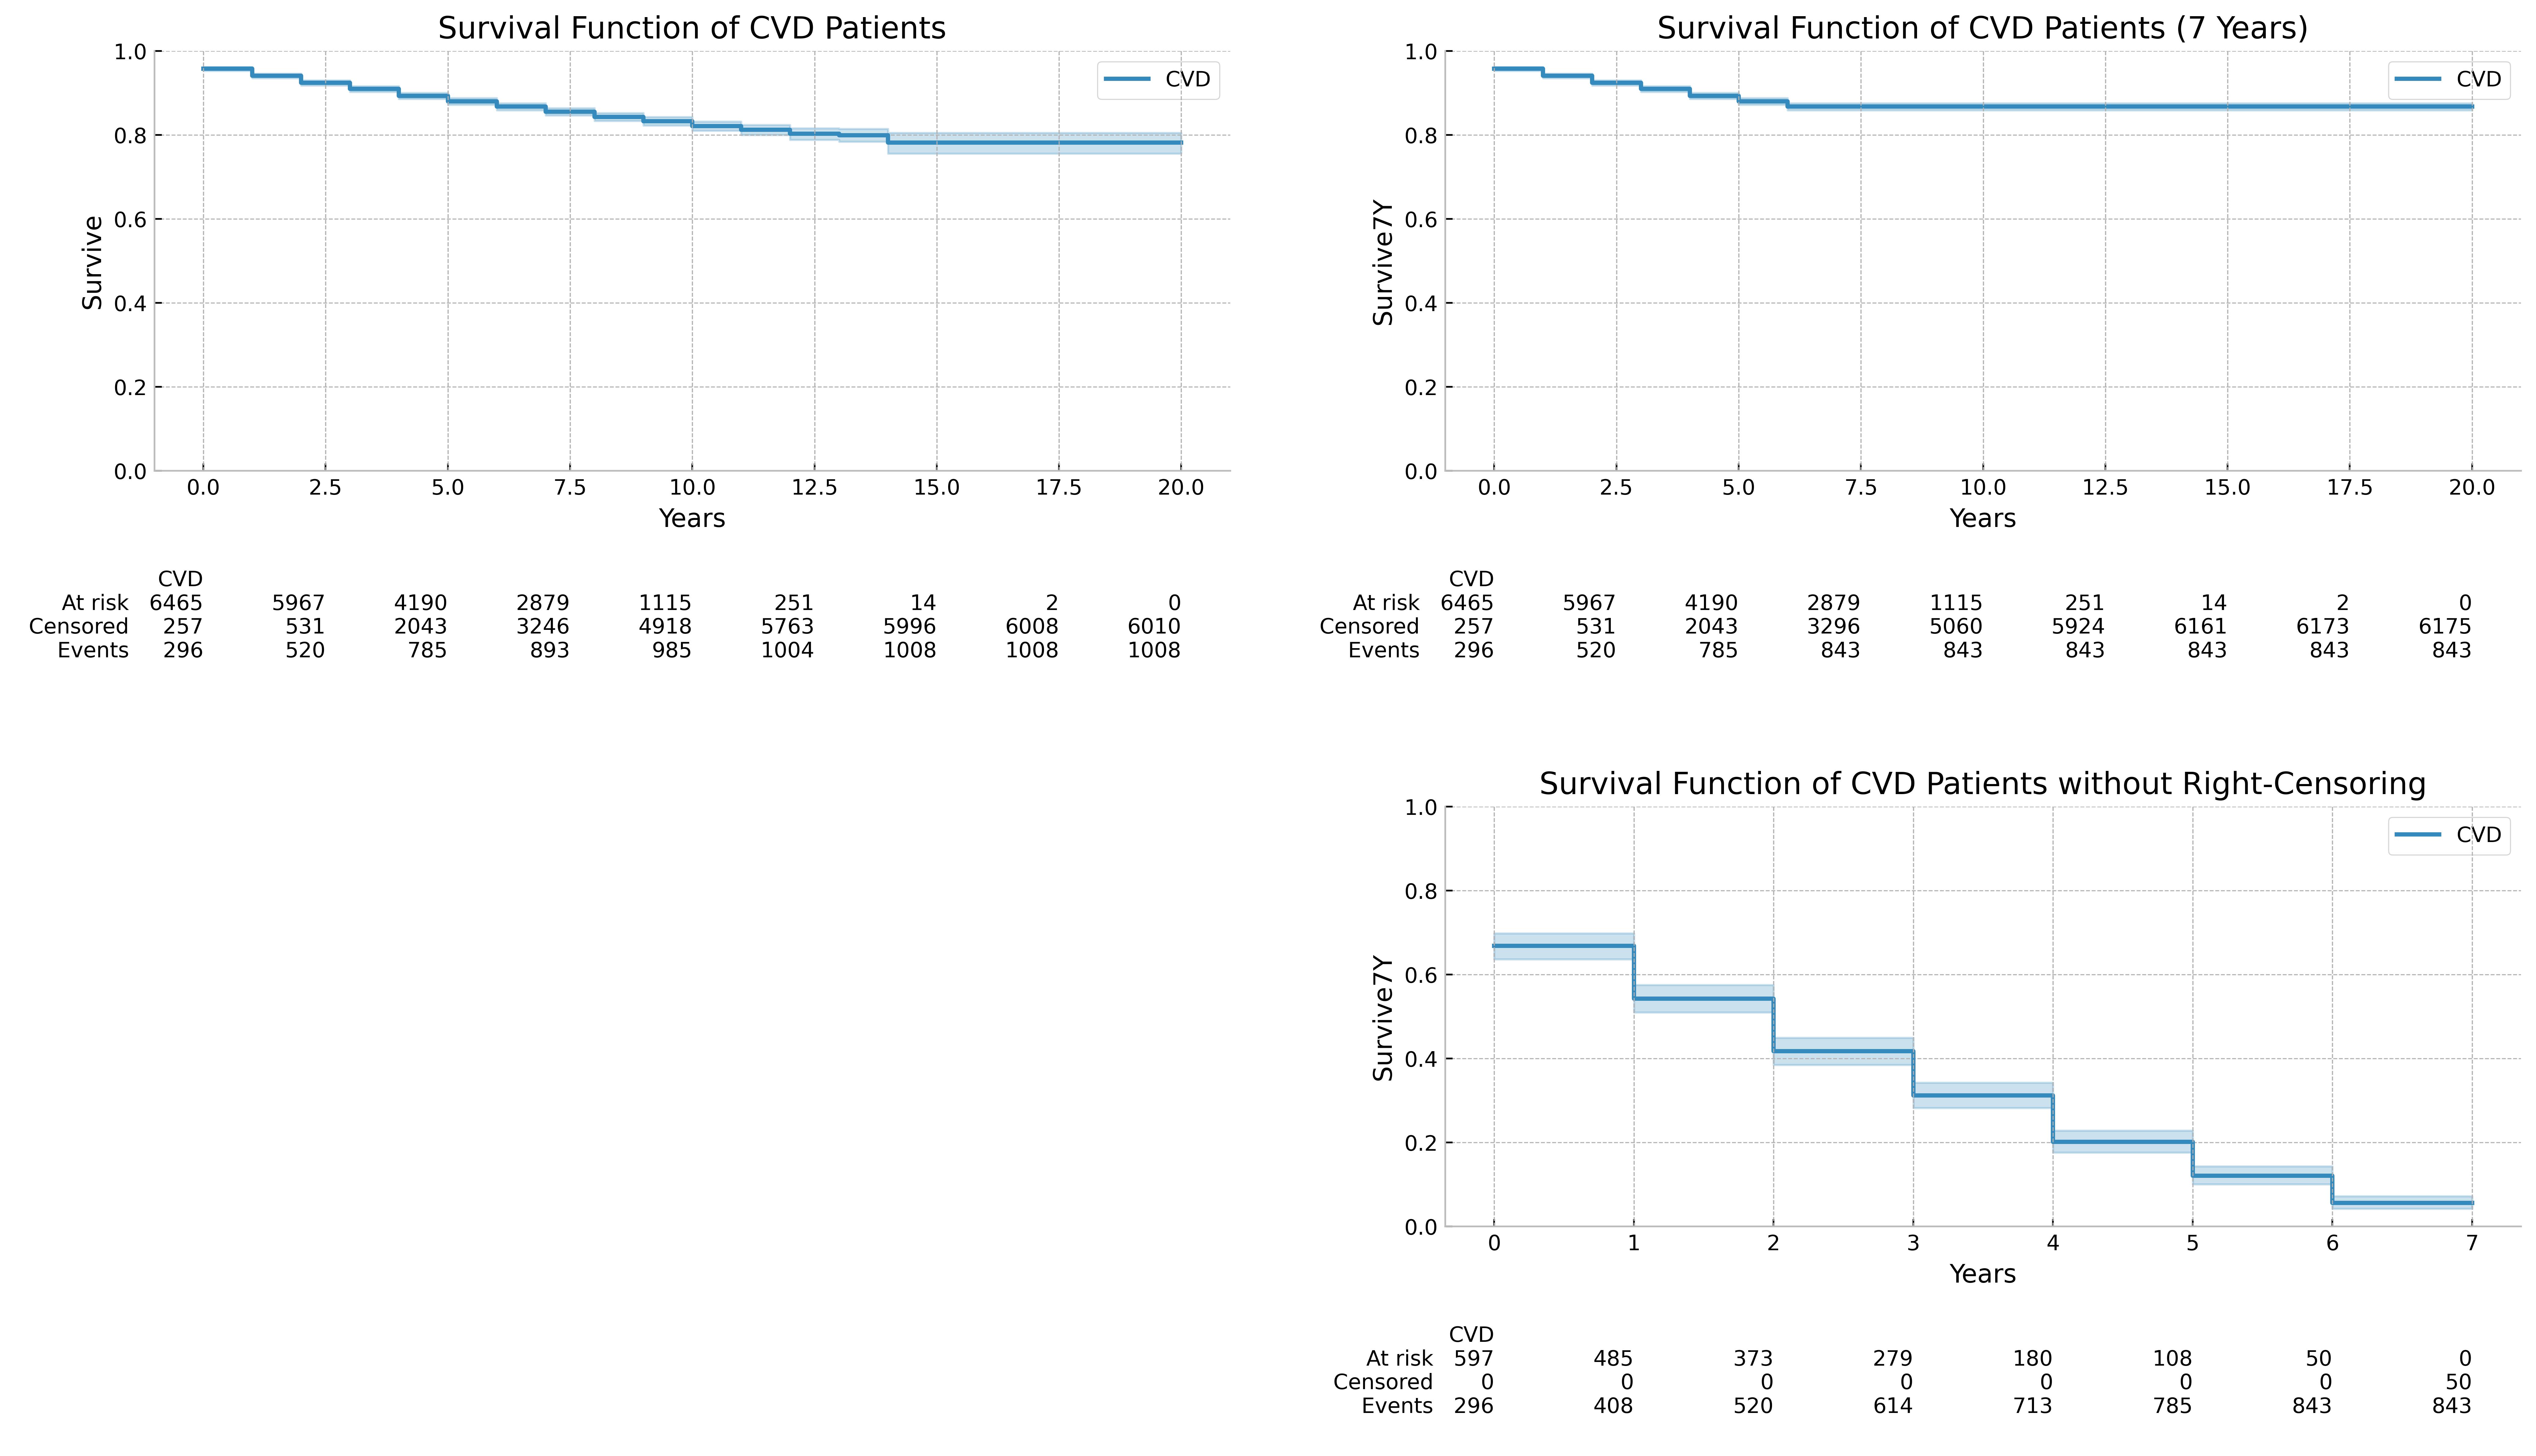

In [42]:
fig = plt.figure(figsize=(20, 10), dpi=500) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.8, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
kmf1 = KaplanMeierFitter()
kmf1.fit(df_surv["duration"], event_observed=df_surv["observed"], label="CVD")
kmf1.plot_survival_function()
plt.title('Survival Function of CVD Patients')
plt.xlabel("Years")
plt.ylabel("Survive")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1)
#display(kmf1.survival_function_at_times(df_surv["duration"].unique()))

plt.subplot2grid(fig_dims, (0, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df_surv["duration"], event_observed=df_surv["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients (7 Years)')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)
#display(kmf2.survival_function_at_times(df_surv["duration"].unique()))


# Without right-censoring
df = df_surv[df_surv["observed"]==1]
df = df[df["duration"]<=7]
plt.subplot2grid(fig_dims, (1, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df["duration"], event_observed=df["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients without Right-Censoring')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)

#plt.savefig(f"{path_images}survival_all_par.png")
# kmf.median_survival_time_
# kmf.confidence_interval_

### Survival Analysis Univariate

In [43]:
# Load the dataset and the extra data
df = pd.read_csv(f"data/raw/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="mixed")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="mixed")

# Create and add target feature `Survive`
df_diff = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: x.days // 365)
years = 7
survive = (df_diff < years) & df["CVD Death"]
survive = (survive + 1) % 2
df[f"Survive{years}Y"] = survive

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
df["duration"] = df_diff
df["observed"] = df["CVD Death"]

# Remove columns that were not found within the old dataset
to_drop = ['Glycemia', 'Primary Dilated\nCardiomyopathy', 'Normal', 'SindromeX', 'AMI', 'PMI', 'Aritmie', 'MIN', 'MIO', 'Miocardite', 'Pericardite', 'Endocardite', 'Valvulopatie', 'MalattiaVasoAorta', 'Ipertensione', 'CardiopatiaCongenita', 'EmboliaPolmonare', 'EPA', 'HR', 'Weight', 'Height', 'BMI', 'Diastolic blood pressure', 'Systolic blood pressure', 'WmsiBas', 'DimSettoIV', 'DimPP', 'vsx', 'B-Blockers', 'Amiodarone', 'Calcium channel blockers', 'Diuretics', 'Antiplatelet', 'Nitrates', 'ACE-inhibitors', 'Ipolipemizzanti', 'Antidiabetici', 'Cause of death', 'Collected by', 'Suicide', 'CABG ', 'Non Fatal AMI (Follow-Up)', 'Ictus', 'PCI']

#Columns with missing values
drop_columns_missing = ['Total cholesterol', 'HDL', 'LDL', 'Triglycerides', 'Creatinina']

# Not useful columns
nu_columns = ["Data of death", "Data prelievo", "Follow Up Data",
                                "Fatal MI or Sudden death", "UnKnown", "Accident", "Total mortality", 
                                "CVD Death", "CAD"]
df = df.drop(columns = to_drop + drop_columns_missing + nu_columns)

# Remove Duration columns from preprocessing (present in data_cvd.csv)
duration_cols = ['Duration_days', 'Duration_years']
df = df.drop(columns=[col for col in duration_cols if col in df.columns])

print(len(df.columns)) 
assert len(df.columns) == 30
#display(df)

30


30
0 Gender (Male = 1)
0.1054 0.10540257705657245 2386 4632
1 Age
0.0 1.582100521804974e-64 3159 3859
2 TSH
0.0008 0.0007545558914218145 4748 2270
3 fT3
0.0 1.4425486035962465e-13 4173 2845
4 fT4
0.0 2.0993567812036364e-24 4094 2924
5 Euthyroid
0.0 4.466207936488057e-38 1940 5078
6 Subclinical primary hypothyroidism (SCH)
0.0 9.147177326738377e-08 6621 397
7 Subclinical primary hyperthyroidism
(SCT)
0.5603 0.5602695934347841 6801 217
8 Low T3
0.0 1.578356733879031e-24 5922 1096
9 Ipotiroidismo
0.0059 0.005924397621200438 6912 106
10 Ipertiroidismo
0.003 0.003036978170276063 6893 125
11 Angina
0.0057 0.005742620354911539 3393 3625
12 Previous CABG
0.0 5.8883329419965874e-30 6461 557
13 Previous PCI
0.0291 0.02905040739020718 6092 926
14 Previous Myocardial Infarction
0.0 1.7911184952789622e-28 5271 1747
15 Acute Myocardial Infarction
0.0 1.0010304160935844e-09 6380 638
16 Angiography
0.0 1.5987578921577053e-05 2650 4368
17 Vessels
0.052 0.052009809847702385 4177 2841
18 Documented resti

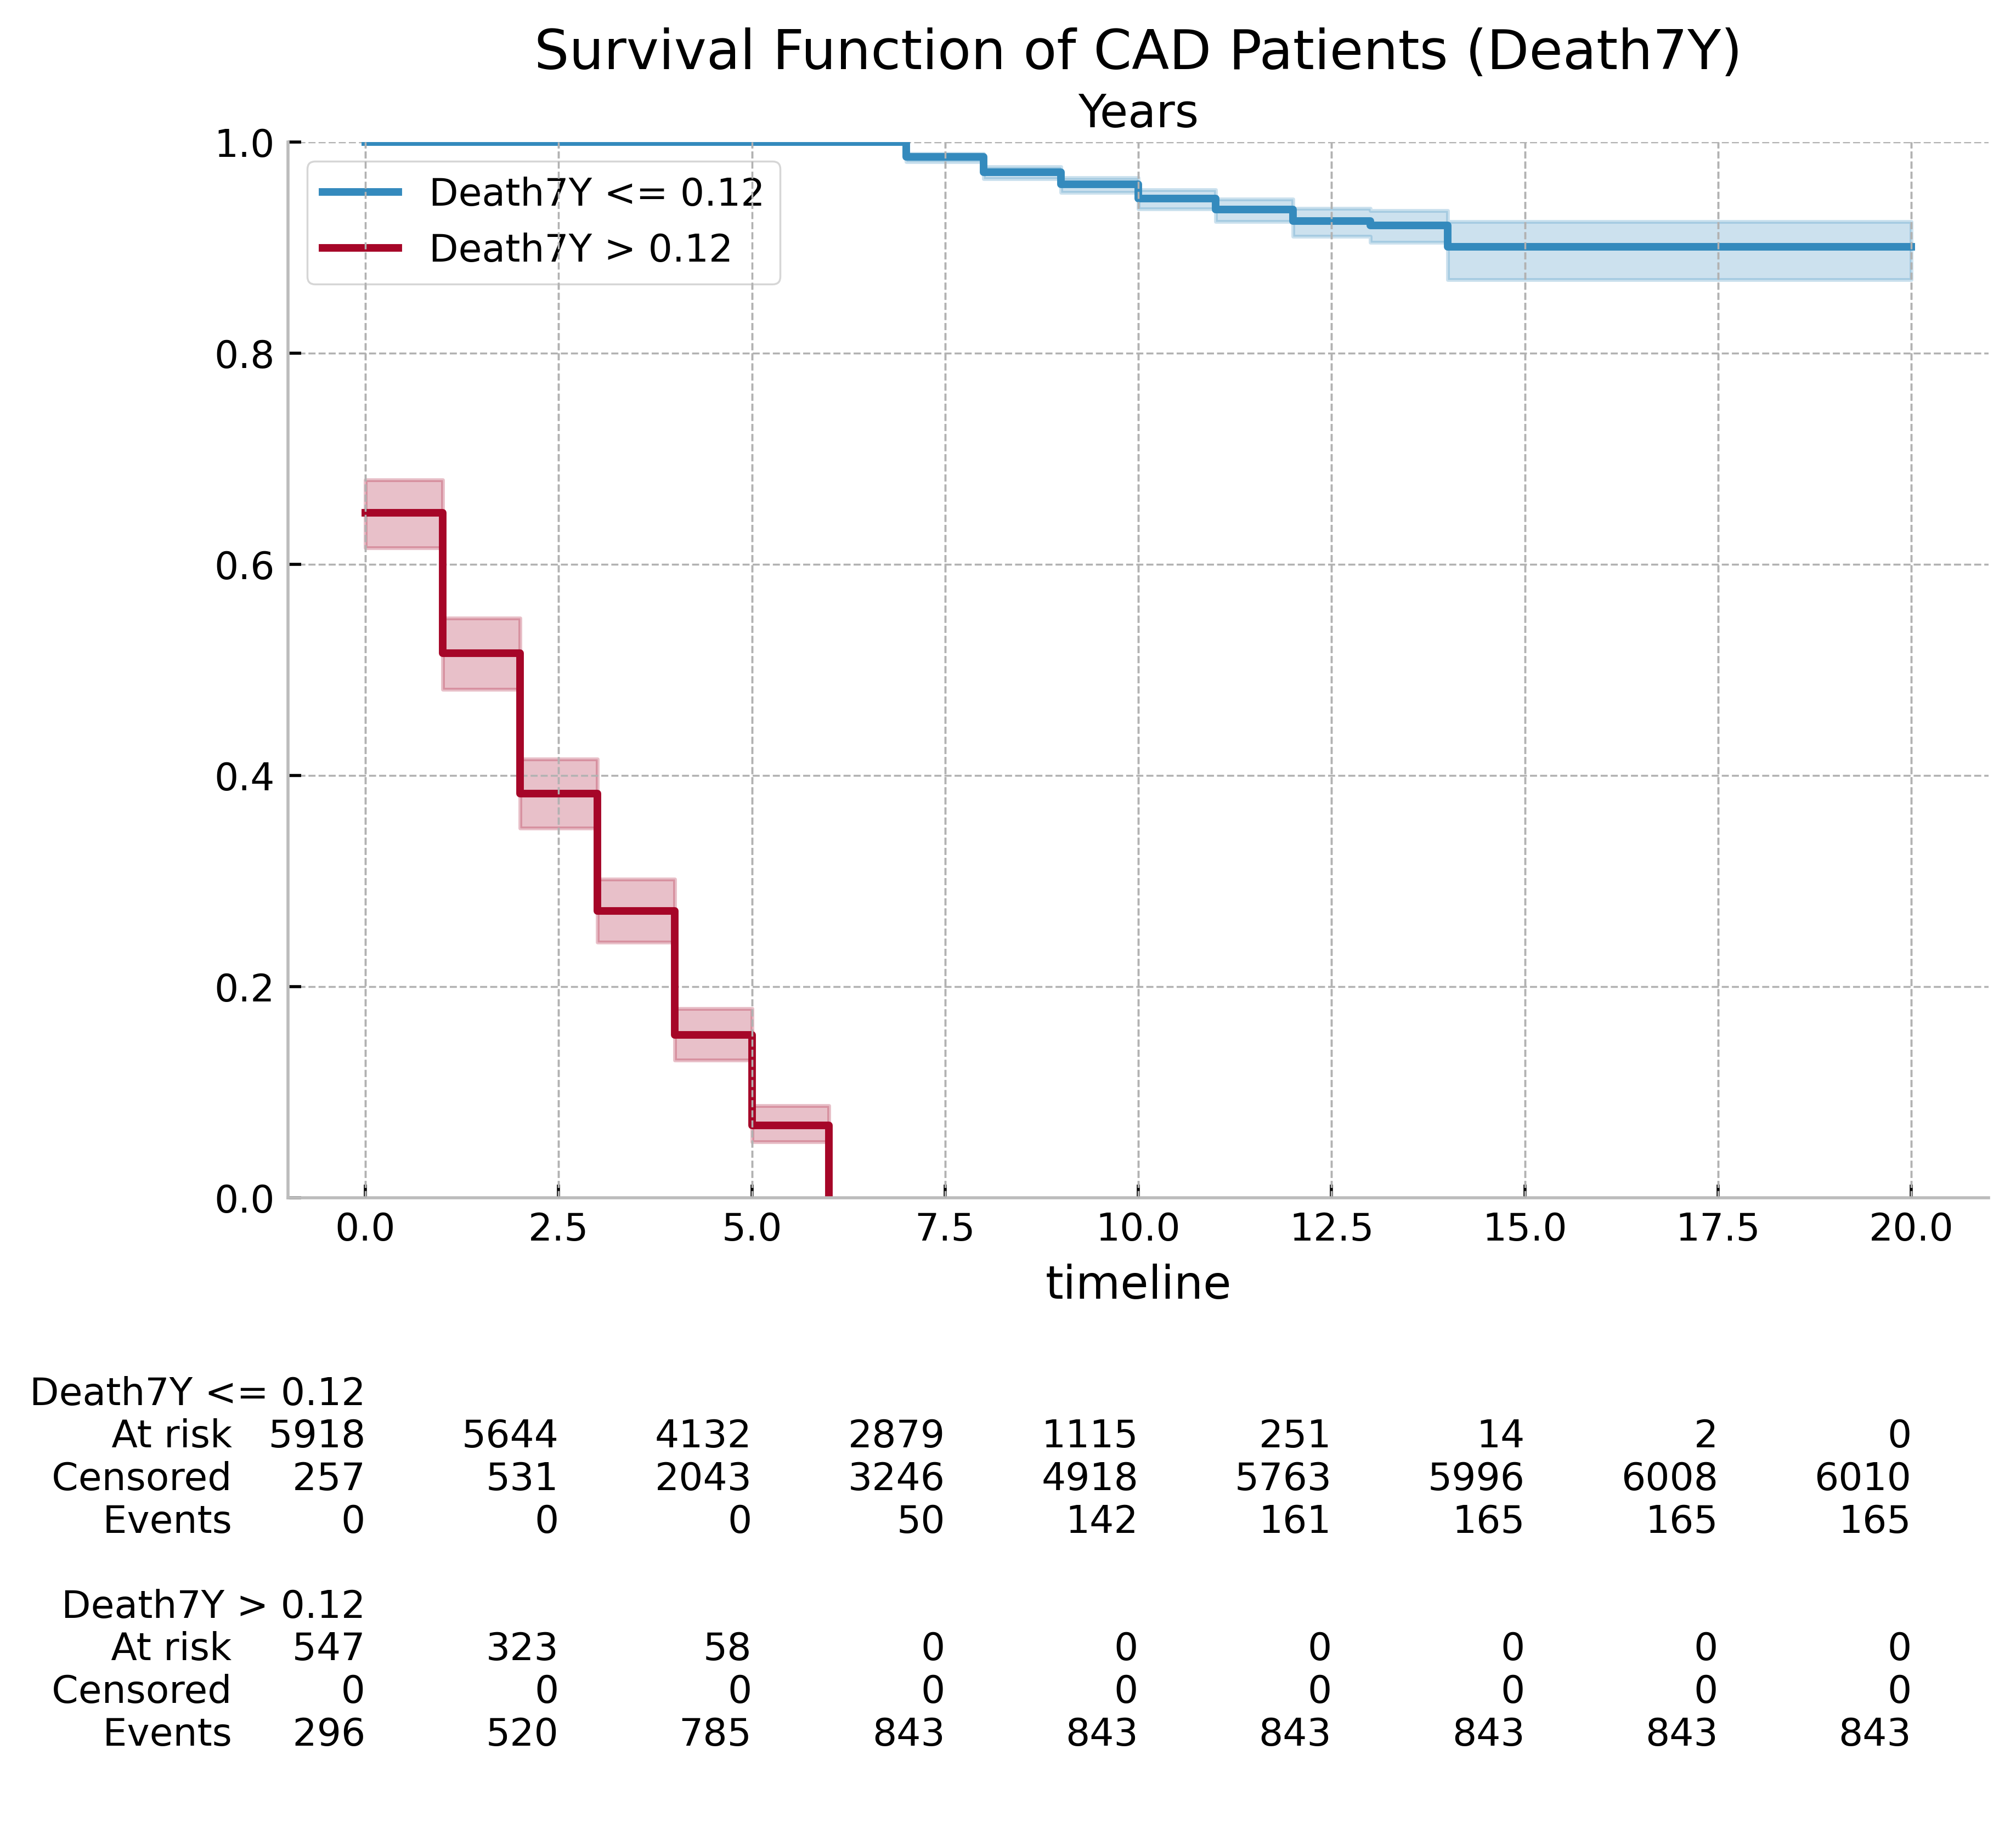

In [44]:
#fig = plt.figure(figsize=(12, 10.5), dpi=400) 
from lifelines.statistics import logrank_test
from contextlib import redirect_stdout
df = df.select_dtypes(exclude=['object','datetime64'])
columns = df.columns
print(len(columns))
for value in enumerate(columns):
    if value[1] == "duration" or value[1] == "observed" or value[1] == "Survive7Y":
        continue
    print(value[0], value[1])
    
    mean = df[value[1]].mean()
    df_under_mean = df[df[value[1]] <= mean]
    df_above_mean = df[df[value[1]] > mean]
    if len(df_under_mean) == 0 or len(df_above_mean) == 0:
        continue
    plt.clf()
    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_under_mean["duration"], event_observed=df_under_mean["observed"], label=f"{value[1]} <= {round(mean,2)}")
    kmf1.plot_survival_function()
    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_above_mean["duration"], event_observed=df_above_mean["observed"], label=f"{value[1]} > {round(mean,2)}")
    ax = kmf2.plot_survival_function()
    plotting.add_at_risk_counts(kmf1, kmf2)
    plt.title(f'Survival Function of CAD Patients ({value[1]})')
    plt.xlabel("Years")
    plt.ylabel("Survivals")
    plt.ylim(0, 1)
    #plt.legend(loc="lower left")
    ax.get_figure().savefig(f"{path_images}{value[1]}.png")
    results = logrank_test(df_under_mean["duration"], df_above_mean["duration"], df_under_mean["observed"], df_above_mean["observed"])
    print(round(results.p_value,4), results.p_value, len(df_under_mean.index), len(df_above_mean.index))

In [45]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')
# Model 27 features
# Drop rows that are not in test set
df_test_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)
#df_test_pred["ModelOutput"].sort_values().median()

### Survival Analysis Model 

In [46]:
from lifelines.statistics import logrank_test
def plot_kmf(df_pred, threshold, variable):
    df_pred_under = df_pred[df_pred["ModelOutput"] <= threshold]
    df_pred_above = df_pred[df_pred["ModelOutput"] > threshold]
    print(df_pred_under["ModelOutput"].mean(),df_pred_above["ModelOutput"].mean())

    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_pred_under["duration"], event_observed=df_pred_under["observed"], label=f"<= {threshold}")
    kmf1.plot_survival_function()
    print(kmf1.survival_function_)

    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_pred_above["duration"], event_observed=df_pred_above["observed"], label=f"> {threshold}")
    kmf2.plot_survival_function(linestyle="--")
    print(kmf2.survival_function_)

    plt.title(f'Survival Function of IHD Patients ({variable})')
    plt.xlabel("Years")
    plt.ylabel("Survivals")

    results = logrank_test(df_pred_under["duration"], df_pred_above["duration"], df_pred_under["observed"], df_pred_above["observed"])
    print(results)
    plt.ylim(0, 1)
    plotting.add_at_risk_counts(kmf1, kmf2)

## Plot the survival function for patients under and over the threshold of the ModelOutput

In [47]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')
# Model 27 features
# Drop rows that are not in test set
df_test_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)
display(df_test_pred), len(df_test_pred.index)

,Death7Y,duration,observed,ID,ModelOutput
Number,,,,,
5,1,3,1,733645,0.655882
6,0,2,0,709391,0.864369
10,1,5,1,236630,0.340998
13,0,7,0,356396,0.978585
18,1,2,1,670697,0.492093
...,...,...,...,...,...
8041,0,4,0,511022,0.864245
8047,0,1,0,364262,0.902768
8051,0,0,0,471177,0.969682


(None, 1404)

0.5643758610265129 0.9190575214202917
           <= 0.75
timeline          
0.0       0.857143
1.0       0.812227
2.0       0.755295
3.0       0.724467
4.0       0.691723
5.0       0.664596
6.0       0.618937
7.0       0.600733
8.0       0.572127
9.0       0.563587
10.0      0.552086
11.0      0.552086
12.0      0.552086
13.0      0.552086
14.0      0.552086
16.0      0.552086
17.0      0.552086
            > 0.75
timeline          
0.0       0.983986
1.0       0.973813
2.0       0.962434
3.0       0.956613
4.0       0.947385
5.0       0.938298
6.0       0.929137
7.0       0.921496
8.0       0.912444
9.0       0.907824
10.0      0.898529
11.0      0.898529
12.0      0.878996
13.0      0.858068
14.0      0.815164
15.0      0.815164
<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         194.08 <0.005    144.13


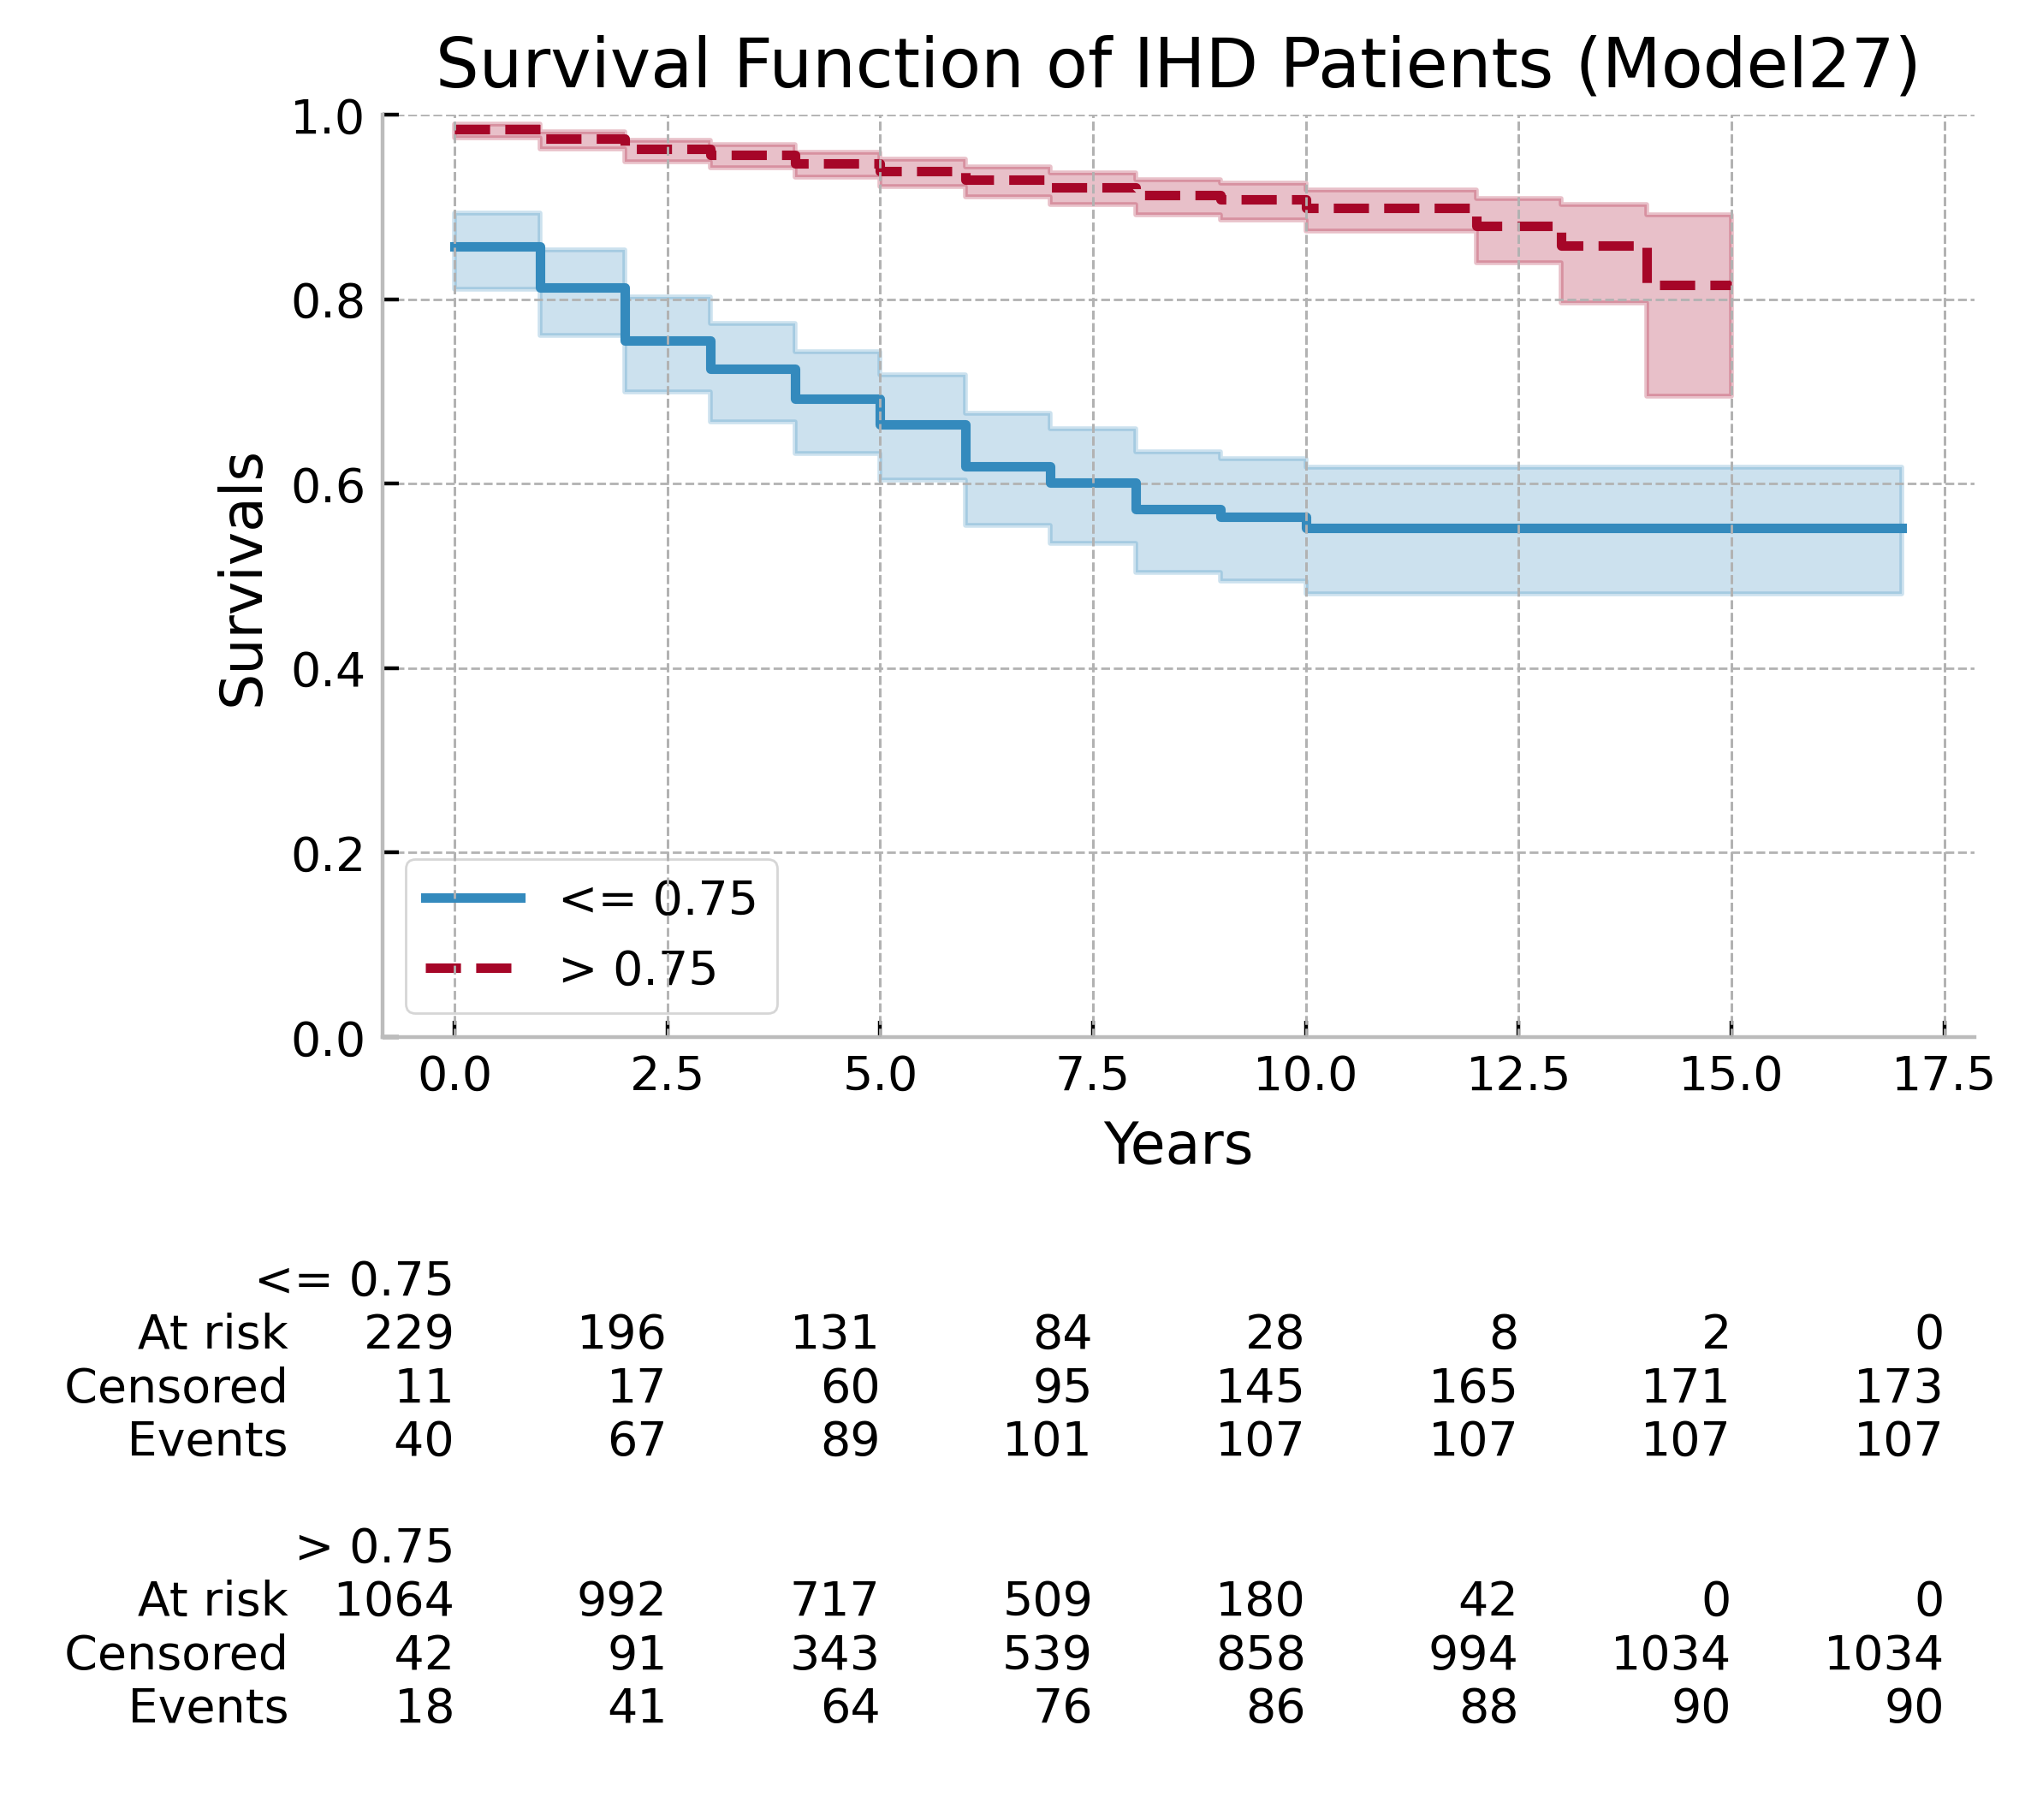

In [48]:
# Plots
fig = plt.figure(figsize=(6, 3.5), dpi=400) 
fig_dims = (1, 1)
fig.subplots_adjust(hspace=1, wspace=0.2)
threshold = 0.75 # median of ModelOutput is 0.911
plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(df_test_pred, threshold=threshold, variable="Model27")
plt.savefig(f"{path_images}survival_model_27.png", bbox_inches="tight", dpi=400)
#plt.savefig(f"{path_images}survival_model_27.tiff", format="tiff", bbox_inches="tight", dpi=400)

## COX Regression and p-value 


In [49]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')

# Model 27 all features
df_test_pred = df.drop(list(set(df.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)
df_test_pred = df_test_pred.drop(["Survive7Y", "Death7Y"],axis=1)


In [50]:
df_test_pred.columns, len(df_test_pred.columns) 

(Index(['Gender (Male = 1)', 'Age', 'TSH', 'fT3', 'fT4', 'Euthyroid',
        'Subclinical primary hypothyroidism (SCH)',
        'Subclinical primary hyperthyroidism\n(SCT)', 'Low T3', 'Ipotiroidismo',
        'Ipertiroidismo', 'Angina', 'Previous CABG', 'Previous PCI',
        'Previous Myocardial Infarction', 'Acute Myocardial Infarction',
        'Angiography', 'Vessels', 'Documented resting \nor exertional ischemia',
        'Post-ischemic Dilated\nCardiomyopathy', 'Smoke\nHistory of smoke',
        'Diabetes\nHistory of diabetes',
        'Hypertension\nHistory of hypertension',
        'Dyslipidemia\nHystory of dyslipidemia', 'Atrial Fibrillation', 'fe',
        'duration', 'observed', 'ModelOutput'],
       dtype='object'),
 29)

Univariate

In [51]:
#i = 17
for key in range(0,26):
    cph = CoxPHFitter()
    cph.fit(df_test_pred.loc[:, [df_test_pred.columns[key], "duration", "observed"]], duration_col='duration', event_col='observed')
    #cph.fit(df_test_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
    print(f"{df_test_pred.columns[key]}: {cph.concordance_index_} {cph.summary['p']}")
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
print(f"ML Indicator (27 variables): {cph.concordance_index_}")

Gender (Male = 1): 0.5317703677284581 covariate
Gender (Male = 1)    0.065031
Name: p, dtype: float64
Age: 0.7330830550318908 covariate
Age    6.900947e-26
Name: p, dtype: float64
TSH: 0.5019731996868819 covariate
TSH    0.369747
Name: p, dtype: float64
fT3: 0.6146818099706799 covariate
fT3    0.00199
Name: p, dtype: float64
fT4: 0.6134311904508252 covariate
fT4    0.000985
Name: p, dtype: float64
Euthyroid: 0.6040376482794718 covariate
Euthyroid    6.621081e-08
Name: p, dtype: float64
Subclinical primary hypothyroidism (SCH): 0.5097432524444979 covariate
Subclinical primary hypothyroidism (SCH)    0.277288
Name: p, dtype: float64
Subclinical primary hyperthyroidism
(SCT): 0.5020125710421366 covariate
Subclinical primary hyperthyroidism\n(SCT)    0.521473
Name: p, dtype: float64
Low T3: 0.5909964658418754 covariate
Low T3    4.079141e-09
Name: p, dtype: float64
Ipotiroidismo: 0.5033025619172461 covariate
Ipotiroidismo    0.48196
Name: p, dtype: float64
Ipertiroidismo: 0.501725391744984

Multivariate Top 27 variables + Model 27

In [52]:
cph = CoxPHFitter(penalizer=0.1)  # L2 regularization
cph.fit(df_test_pred, duration_col='duration', event_col='observed')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1404 total observations, 1207 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1404
number of events observed = 197
   partial log-likelihood = -1245.45
         time fit was run = 2025-10-01 14:28:59 UTC

---
                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                    
Gender (Male = 1)                            0.13      1.14      0.12           -0.11            0.37                0.90                1.45
Age                                          0.02      1.03      0.00            0.02            0.03                1.02                1.03
TSH                                          0.01      1.01      0.02           -0.03            0.04                0.97                1.04
fT3                                         -0.01      0.99      0.02           -0.06            0.03                0.94                1.03
fT4                                          0.02      1.02      0.01           -0.01            0.04                0.99                1.05
Euthyroid                                   -0.17      0.85      0.14           -0.45            0.11                0.64                1.12
Subclinical primary hypothyroidism (SCH)    -0.04      0.96      0.23           -0.48            0.41                0.62                1.50
Subclinical primary hyperthyroidism\n(SCT)  -0.09      0.91      0.33           -0.73            0.55                0.48                1.74
Low T3                                       0.33      1.38      0.16            0.01            0.64                1.01                1.89
Ipotiroidismo                               -0.22      0.80      0.40           -1.01            0.56                0.37                1.75
Ipertiroidismo                              -0.07      0.93      0.44           -0.94            0.80                0.39                2.23
Angina                                      -0.02      0.98      0.12           -0.25            0.21                0.78                1.23
Previous CABG                                0.52      1.68      0.18            0.16            0.87                1.18                2.40
Previous PCI                                 0.25      1.29      0.16           -0.06            0.57                0.94                1.77
Previous Myocardial Infarction               0.08      1.09      0.13           -0.17            0.34                0.84                1.40
Acute Myocardial Infarction                  0.19      1.21      0.18           -0.17            0.55                0.84                1.73
Angiography                                 -0.25      0.78      0.13           -0.50           -0.01                0.61                0.99
Vessels                                      0.09      1.10      0.06           -0.02            0.20                0.98                1.23
Documented resting \nor exertional ischemia -0.15      0.86      0.12           -0.39            0.10                0.68                1.10
Post-ischemic Dilated\nCardiomyopathy        0.25      1.28      0.18           -0.09            0.59                0.91                1.81
Smoke\nHistory of smoke                     -0.14      0.87      0.12           -0.37            0.09                0.69                1.09
Diabetes\nHistory of diabetes                0.38      1.47      0.12            0.14            0.63                1.15                1.87
Hypertension\nHistory of hypertension        0.01      1.01      0.11           -0.21            0.23                0.81                1.26
Dyslipidemia\nHyst

Multivariate all variables

In [53]:
df_feat = df_test_pred.drop(columns=["ModelOutput"])
cph = CoxPHFitter(penalizer=0.1)  # L2 regularization
cph.fit(df_feat, duration_col='duration', event_col='observed')
cph.print_summary()
cph.concordance_index_


<lifelines.CoxPHFitter: fitted with 1404 total observations, 1207 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1404
number of events observed = 197
   partial log-likelihood = -1256.26
         time fit was run = 2025-10-01 14:28:59 UTC

---
                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                    
Gender (Male = 1)                            0.11      1.12      0.12           -0.13            0.35                0.88                1.42
Age                                          0.03      1.03      0.00            0.02            0.04                1.02                1.04
TSH                                          0.01      1.01      0.02           -0.02            0.04                0.98                1.04
fT3                                         -0.02      0.98      0.02           -0.06            0.03                0.94                1.03
fT4                                          0.02      1.02      0.01           -0.00            0.05                1.00                1.05
Euthyroid                                   -0.22      0.80      0.14           -0.50            0.06                0.61                1.06
Subclinical primary hypothyroidism (SCH)     0.03      1.03      0.23           -0.42            0.48                0.66                1.61
Subclinical primary hyperthyroidism\n(SCT)  -0.12      0.89      0.32           -0.75            0.52                0.47                1.68
Low T3                                       0.39      1.47      0.16            0.07            0.70                1.08                2.01
Ipotiroidismo                               -0.19      0.83      0.40           -0.98            0.60                0.38                1.82
Ipertiroidismo                              -0.15      0.86      0.44           -1.02            0.71                0.36                2.04
Angina                                      -0.03      0.97      0.12           -0.25            0.20                0.78                1.22
Previous CABG                                0.55      1.73      0.18            0.19            0.91                1.21                2.47
Previous PCI                                 0.23      1.26      0.16           -0.09            0.54                0.92                1.72
Previous Myocardial Infarction               0.16      1.17      0.13           -0.09            0.41                0.91                1.50
Acute Myocardial Infarction                  0.21      1.23      0.18           -0.15            0.57                0.86                1.77
Angiography                                 -0.29      0.75      0.13           -0.53           -0.04                0.59                0.96
Vessels                                      0.11      1.12      0.06            0.00            0.22                1.00                1.25
Documented resting \nor exertional ischemia -0.16      0.85      0.12           -0.40            0.08                0.67                1.08
Post-ischemic Dilated\nCardiomyopathy        0.40      1.49      0.17            0.06            0.73                1.06                2.09
Smoke\nHistory of smoke                     -0.15      0.86      0.12           -0.38            0.08                0.69                1.08
Diabetes\nHistory of diabetes                0.42      1.52      0.12            0.18            0.67                1.19                1.94
Hypertension\nHistory of hypertension       -0.01      0.99      0.11           -0.23            0.21                0.79                1.23
Dyslipidemia\nHyst

np.float64(0.8348672722135503)

In [54]:
from auto_export_notebook import export_current_notebook


html_path = export_current_notebook(
    globals(),
    wait_for_disk_save=True,   # wait for Auto Save
    wait_timeout_sec=8.0
)
print("Exported to:", html_path)

<IPython.core.display.Javascript object>

Exported to: /home/ileniag/buzi_ml4cad_noncvd/exported_notebooks/5_survival_analysis_27features_20251001_162859.html
